In [5]:
from scipy.io import loadmat
from netCDF4 import Dataset
import numpy as np
import gsw



In [48]:
import scipy.sparse

#Units of "per year" for the transport matrix
base_transport = loadmat("OCIM2_48L_base_transport.mat")
#filter out the 'exit flux'
pos_base_tr_mat = base_transport['TR'].multiply(base_transport['TR'] > 0)
#normalize to get fractional contributions. Row is dest, col is source
transition_prob_mat = scipy.sparse.diags(1.0/np.asarray(np.sum(pos_base_tr_mat, axis=1)).flatten()) @ pos_base_tr_mat

In [6]:
data = Dataset("OCIM2_48L_base_data.nc")
tridx_to_fullgrid_idxs = np.nonzero(data.variables['ocnmask'][:].data)

In [8]:
list(data.variables.keys())

['ocnmask',
 'tlat',
 'tlon',
 'tz',
 'ulat',
 'ulon',
 'wz',
 'vol',
 'area',
 'kappa_para',
 'kappa_perp',
 'ptemp',
 'salt',
 'Delta14C',
 'del3He',
 'year_cfc11',
 'year_cfc12',
 'cfc11',
 'cfc12',
 'heatflux',
 'saltflux',
 'mld',
 'uvel',
 'vvel',
 'wvel',
 'ssh',
 'mantle_3he_flux']

In [25]:
ocnmask = data.variables['ocnmask'][:].data==1.0
ulat = data.variables['ulon'][:].data #latlon are swapped in file
ulon = data.variables['ulat'][:].data #latlon are swapped in file
wz = data.variables['wz'][:].data
salt = data.variables['salt'][:].data #units of psu means 'practical' sal?
ptemp = data.variables['ptemp'][:].data #ptempt wrt surface?
ssh = data.variables['ssh'][:].data #reference pressure? assuming ~0 dbar

In [191]:
ulat_ocnvec = ulat.ravel()[ocnmask.ravel()]
ulon_ocnvec = ulon.ravel()[ocnmask.ravel()]
#convert ulon to have negative longitudes
ulon_ocnvec = ulon_ocnvec*(ulon_ocnvec <= 180) + (-(360-ulon_ocnvec)*(ulon_ocnvec > 180))

depth_ocnvec = wz.ravel()[ocnmask.ravel()]

#z is expected to be negative in the ocean
#gives pressure in dbar
#removing geo_strf_dyn_height still gives stuff
# that's pretty correlated
p_ocnvec = gsw.p_from_z(
    z=-depth_ocnvec,
    lat=ulat_ocnvec,
    geo_strf_dyn_height=np.tile(ssh[None,:,:], (48,1,1)).ravel()[ocnmask.ravel()])

#absolute salinity
absal_ocnvec = gsw.SA_from_SP(
    SP=salt.ravel()[ocnmask.ravel()],
    p=p_ocnvec,
    lon=ulon_ocnvec,
    lat=ulat_ocnvec)

ctemp_ocnvec = gsw.CT_from_pt(
    SA=absal_ocnvec,
    pt=ptemp.ravel()[ocnmask.ravel()]) #assumes 0 dbar for pt

sig0_ocnvec = gsw.sigma0(SA=absal_ocnvec,CT=ctemp_ocnvec)
sig2_ocnvec = gsw.sigma2(SA=absal_ocnvec,CT=ctemp_ocnvec)
sig4_ocnvec = gsw.sigma4(SA=absal_ocnvec,CT=ctemp_ocnvec)


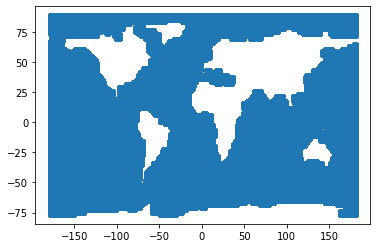

In [192]:
plt.scatter(ulon_ocnvec, ulat_ocnvec)

In [193]:
#copying filter conditions from
# https://colab.research.google.com/github/nitrogenlab/GP15_watermassanalysis/blob/8aba68bf38940ffa7bc84afd7cedc5ac4380ecd2/GP15_Defining_Watermass_Subtypes.ipynb#scrollTo=h5hNQdcE2tnn

def get_nonzero_idxs(lat_min, lat_max,
                     lon_min, lon_max,
                     sig0_min=0, sig0_max=np.inf, 
                     sig2_min=0, sig2_max=np.inf,
                     sig4_min=0, sig4_max=np.inf):
    
    #need to subtract 180 cos ulon_ocnvec goes from 0 to 360
    nonzero_idxs = np.nonzero(
        (ulat_ocnvec >= lat_min)*(ulat_ocnvec <= lat_max)
       *((ulon_ocnvec) >= lon_min)*((ulon_ocnvec) <= lon_max)
       *(sig0_ocnvec >= sig0_min)*(sig0_ocnvec <= sig0_max)
       *(sig2_ocnvec >= sig2_min)*(sig2_ocnvec <= sig2_max)
       *(sig4_ocnvec >= sig4_min)*(sig4_ocnvec <= sig4_max)
    )[0]
    
    return nonzero_idxs

filter_conditions = {
    "AAIW": {"lat_min":-55.0, "lat_max":-43.0,
             "lon_min":-90, "lon_max":-80,
             "sig0_min":27.05, "sig0_max":27.15},
    "NPIW": {"lat_min":34.0, "lat_max":37.0, 
             "lon_min":140.0, "lon_max":153.0, 
             "sig0_min":26.5, "sig0_max":27.4, 
             #"ox_min":0, "ox_max":150.0, #TODO: think about this
             },
    "UCDW": {"lat_min":-49.5, "lat_max":-44.5, 
             "lon_min":-157.0, "lon_max":-147.0,
             "sig0_min":27.35, "sig0_max":27.75,
             },
    "LCDW": {"lat_min":-66.5, "lat_max":-61.5, 
             "lon_min":-100.0, "lon_max":150.0,
             "sig0_min":27.79, "sig0_max":27.83,
             },
    "AABW": {"lat_min":-66.5, "lat_max":-61.5, 
             "lon_min":-100.0, "lon_max":150.0,
             "sig4_min":46.04, "sig4_max":200,
             },
    "PDW": {"lat_min":39.0, "lat_max":51.0, 
             "lon_min":-170.0, "lon_max":-133.0,
             "sig0_min":27.6, "sig0_max":200,
             "sig4_min":0, "sig4_max":45.88,
            },
    "EqIW": {"lat_min":-5, "lat_max":5, 
             "lon_min":-90.0, "lon_max":-80.0,
             "sig0_min": 26.86, "sig0_max": 27.3,
             },
    "PSUW": {"lat_min":50, "lat_max":58, 
             "lon_min":-155, "lon_max":-140,
             "sig0_min": 25.29, "sig0_max": 26.86,
             },
    "ENPCW": {"lat_min":16, "lat_max":26, 
              "lon_min":-170, "lon_max":-140,
              "sig0_min": 25.29, "sig0_max": 26.86,
              },
    "ESSW": {"lat_min":-5, "lat_max":5, 
             "lon_min":-90.0, "lon_max":-80.0,
             "sig0_min": 25.29, "sig0_max": 26.86,
             },
    "SPCW": {"lat_min":-30, "lat_max":-20, 
             "lon_min":-152, "lon_max":-130, 
             "sig0_min": 25.29, "sig0_max": 26.86,
             },
    "SPSTSW": {"lat_min":-20, "lat_max":-15, 
               "lon_min":-152, "lon_max":-142, 
               "sig0_min": 25.29, "sig0_max": 26.86,
              }
}

endmem_to_nonzeroidxs = dict([(the_key, set(get_nonzero_idxs(**val)))
                              for the_key,val in filter_conditions.items()])

AABW
zero out len: 405386
multiplied
starting init
starting copy
finished copy
ending init
convergence sum: 0.9310782018456131
convergence max: 8.856447378657872e-05
5000
Time: 34.92484498023987 s
convergence sum: 0.3962106443984579
convergence max: 4.381687246490795e-05
10000
Time: 70.04870295524597 s
convergence sum: 0.354640372890492
convergence max: 2.631159735244637e-05
15000
Time: 104.88551592826843 s
convergence sum: 0.338221653256932
convergence max: 2.065459996269947e-05
20000
Time: 140.0492079257965 s
convergence sum: 0.3278830381659883
convergence max: 1.6593736321679486e-05
25000
Time: 174.5875289440155 s
convergence sum: 0.31859664166988555
convergence max: 1.3611903272758852e-05
30000
Time: 208.26162719726562 s
convergence sum: 0.30861335017709346
convergence max: 1.1471769974791268e-05
35000
Time: 241.94927191734314 s
convergence sum: 0.29791780826675307
convergence max: 9.570706443029486e-06
40000
Time: 275.78911685943604 s
convergence sum: 0.2870320254370009
convergenc

convergence sum: 0.03356342155633979
convergence max: 4.2664141036707903e-07
380000
Time: 2469.4720709323883 s
convergence sum: 0.032762184328692864
convergence max: 4.2334388208886686e-07
385000
Time: 2498.158523797989 s
convergence sum: 0.03198594100231085
convergence max: 4.202386460067098e-07
390000
Time: 2529.175817966461 s
convergence sum: 0.031233786654440817
convergence max: 4.179563658085472e-07
395000
Time: 2560.4322040081024 s
convergence sum: 0.030504851705582984
convergence max: 4.155193619598263e-07
400000
Time: 2593.063978910446 s
convergence sum: 0.02979830037284304
convergence max: 4.129361243915275e-07
405000
Time: 2625.828973054886 s
convergence sum: 0.029113329211749226
convergence max: 4.1021496373361277e-07
410000
Time: 2657.8961079120636 s
convergence sum: 0.028449165739255274
convergence max: 4.0736399743723783e-07
415000
Time: 2689.0396490097046 s
convergence sum: 0.027805067132166628
convergence max: 4.043911466800054e-07
420000
Time: 2721.264361858368 s
conve

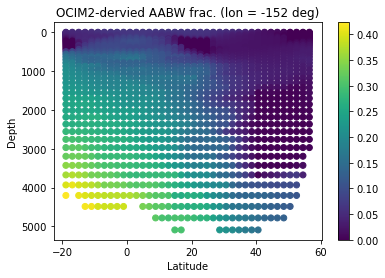

AAIW
zero out len: 405386
multiplied
starting init
starting copy
finished copy
ending init
convergence sum: 0.21123873666938978
convergence max: 3.522291495383634e-05
5000
Time: 31.307981967926025 s
convergence sum: 0.14823431286235417
convergence max: 1.8927839623122944e-05
10000
Time: 63.93454718589783 s
convergence sum: 0.1290627791570206
convergence max: 1.3954192068177385e-05
15000
Time: 96.84944701194763 s
convergence sum: 0.11875069269322769
convergence max: 1.2061691341075376e-05
20000
Time: 129.84391117095947 s
convergence sum: 0.11205244860267301
convergence max: 1.008883056097254e-05
25000
Time: 163.24893498420715 s
convergence sum: 0.1069334797819098
convergence max: 7.909474246059478e-06
30000
Time: 194.91725611686707 s
convergence sum: 0.10242686051188811
convergence max: 5.991277332861866e-06
35000
Time: 227.4941051006317 s
convergence sum: 0.09816886399792334
convergence max: 4.466774225164727e-06
40000
Time: 259.94634199142456 s
convergence sum: 0.09409140715111286
con

convergence sum: 0.01339140246197822
convergence max: 1.9001518709871323e-07
375000
Time: 2372.633754968643 s
convergence sum: 0.013085330269157655
convergence max: 1.888017468545944e-07
380000
Time: 2404.8459191322327 s
convergence sum: 0.012788476762599742
convergence max: 1.875219457353472e-07
385000
Time: 2436.3088710308075 s
convergence sum: 0.01250051976162643
convergence max: 1.8617995547337562e-07
390000
Time: 2467.9027700424194 s
convergence sum: 0.01222114864447925
convergence max: 1.8477982507980606e-07
395000
Time: 2500.027776002884 s
convergence sum: 0.011950063957152202
convergence max: 1.833254802685591e-07
400000
Time: 2531.9605741500854 s
convergence sum: 0.01168697703351328
convergence max: 1.8182072155509266e-07
405000
Time: 2563.607404947281 s
convergence sum: 0.011431609626973654
convergence max: 1.8026922377761823e-07
410000
Time: 2594.7031462192535 s
convergence sum: 0.011183693552795212
convergence max: 1.7867453559056168e-07
415000
Time: 2627.3086371421814 s
co

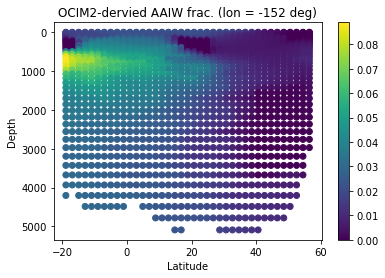

ENPCW
zero out len: 405386
multiplied
starting init
starting copy
finished copy
ending init
convergence sum: 0.13607470080169168
convergence max: 1.1281089868184213e-05
5000
Time: 34.44476008415222 s
convergence sum: 0.11451076242987145
convergence max: 6.57697157368381e-06
10000
Time: 68.33511400222778 s
convergence sum: 0.10675228883853513
convergence max: 4.972854734504317e-06
15000
Time: 102.49621510505676 s
convergence sum: 0.1010895827336015
convergence max: 4.249863255666175e-06
20000
Time: 135.4955859184265 s
convergence sum: 0.09651413386467748
convergence max: 3.553550312167253e-06
25000
Time: 168.6631588935852 s
convergence sum: 0.09284272567573702
convergence max: 3.1505666754083617e-06
30000
Time: 201.5253779888153 s
convergence sum: 0.08978876929941701
convergence max: 2.8904503874827014e-06
35000
Time: 235.03553915023804 s
convergence sum: 0.08706124311127732
convergence max: 2.675145802807921e-06
40000
Time: 269.2683391571045 s
convergence sum: 0.08446759714603107
conve

convergence sum: 0.010156719136918662
convergence max: 1.4962518440908568e-07
375000
Time: 2508.4242322444916 s
convergence sum: 0.009896721318563605
convergence max: 1.4217018873274867e-07
380000
Time: 2542.2630150318146 s
convergence sum: 0.009645294862657267
convergence max: 1.3507600515882956e-07
385000
Time: 2575.6366901397705 s
convergence sum: 0.00940211138917791
convergence max: 1.283264211560109e-07
390000
Time: 2609.1976239681244 s
convergence sum: 0.009166856592420378
convergence max: 1.21905829764124e-07
395000
Time: 2642.838346004486 s
convergence sum: 0.008939229549509427
convergence max: 1.1579921005422378e-07
400000
Time: 2676.450569152832 s
convergence sum: 0.00871894206770841
convergence max: 1.0999212074480624e-07
405000
Time: 2709.9416060447693 s
convergence sum: 0.008505718068205555
convergence max: 1.0447068593544273e-07
410000
Time: 2743.961678981781 s
convergence sum: 0.008299293004327916
convergence max: 9.922159693864785e-08
415000
Time: 2777.3130900859833 s
c

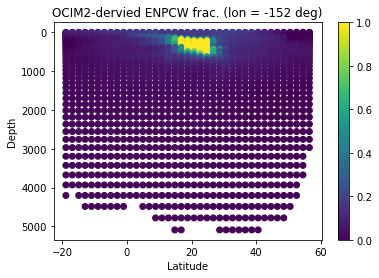

ESSW
zero out len: 405386
multiplied
starting init
starting copy
finished copy
ending init
convergence sum: 0.21690601912693347
convergence max: 0.0001483403153383911
5000
Time: 32.832005977630615 s
convergence sum: 0.1643953429983542
convergence max: 7.484854993844436e-05
10000
Time: 66.35019183158875 s
convergence sum: 0.12542781932710892
convergence max: 4.2263435208966804e-05
15000
Time: 100.00939798355103 s
convergence sum: 0.10116317003689497
convergence max: 2.406931009607538e-05
20000
Time: 133.15373969078064 s
convergence sum: 0.08796923130536462
convergence max: 1.3797937781112601e-05
25000
Time: 167.10785102844238 s
convergence sum: 0.08124216382554952
convergence max: 8.762602708711764e-06
30000
Time: 200.7546329498291 s
convergence sum: 0.07774436501107695
convergence max: 5.824185325159492e-06
35000
Time: 233.9710829257965 s
convergence sum: 0.07572270658211178
convergence max: 4.672032180685903e-06
40000
Time: 267.62618708610535 s
convergence sum: 0.07431830650936153
con

convergence sum: 0.008985794845379825
convergence max: 1.495465908885052e-07
375000
Time: 2495.266096830368 s
convergence sum: 0.008724331934675865
convergence max: 1.4273306836454225e-07
380000
Time: 2527.962142944336 s
convergence sum: 0.008472322816875199
convergence max: 1.3620214833753863e-07
385000
Time: 2561.249983072281 s
convergence sum: 0.008229378990655603
convergence max: 1.29944654148062e-07
390000
Time: 2593.8226540088654 s
convergence sum: 0.007995129531196713
convergence max: 1.2395146056776163e-07
395000
Time: 2626.428400993347 s
convergence sum: 0.007769220230859091
convergence max: 1.1821352530194673e-07
400000
Time: 2659.765067100525 s
convergence sum: 0.007551312781790683
convergence max: 1.1272191713374013e-07
405000
Time: 2692.912978887558 s
convergence sum: 0.007341083999051842
convergence max: 1.074678304679999e-07
410000
Time: 2726.101957798004 s
convergence sum: 0.007138225082210249
convergence max: 1.0244261219871653e-07
415000
Time: 2759.295224905014 s
conv

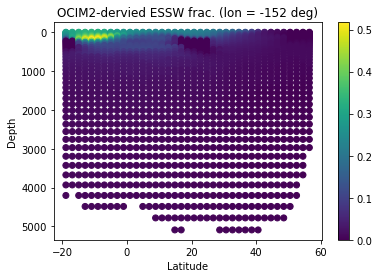

EqIW
zero out len: 405386
multiplied
starting init
starting copy
finished copy
ending init
convergence sum: 0.058589691478992574
convergence max: 3.7880873217464167e-06
5000
Time: 31.994035959243774 s
convergence sum: 0.02691524130887718
convergence max: 2.272148010937919e-06
10000
Time: 64.54367709159851 s
convergence sum: 0.02360726243086918
convergence max: 1.4557039505272429e-06
15000
Time: 97.98897218704224 s
convergence sum: 0.022205546003601067
convergence max: 1.0939503542941459e-06
20000
Time: 130.6923189163208 s
convergence sum: 0.02140462737863737
convergence max: 9.073018082828704e-07
25000
Time: 163.504536151886 s
convergence sum: 0.020836378668581224
convergence max: 7.580833289132227e-07
30000
Time: 195.15085101127625 s
convergence sum: 0.020325539445473863
convergence max: 6.556618462206371e-07
35000
Time: 228.60075402259827 s
convergence sum: 0.019802391838601593
convergence max: 6.000962445573688e-07
40000
Time: 261.7655220031738 s
convergence sum: 0.01925173834819306

convergence sum: 0.0023789761694669935
convergence max: 2.686921871802861e-08
375000
Time: 2449.779184103012 s
convergence sum: 0.002319109025543166
convergence max: 2.5591656509227345e-08
380000
Time: 2481.787852048874 s
convergence sum: 0.0022611954270834052
convergence max: 2.4372017376483868e-08
385000
Time: 2514.3960189819336 s
convergence sum: 0.002205160956549652
convergence max: 2.320797512500583e-08
390000
Time: 2547.3380970954895 s
convergence sum: 0.0021509343672353764
convergence max: 2.2097267758647288e-08
395000
Time: 2580.2707710266113 s
convergence sum: 0.002098447427370764
convergence max: 2.1784502497908254e-08
400000
Time: 2613.0145049095154 s
convergence sum: 0.002047634773208552
convergence max: 2.1676778367077376e-08
405000
Time: 2647.573229074478 s
convergence sum: 0.0019984337705693327
convergence max: 2.1560944048377995e-08
410000
Time: 2680.7218890190125 s
convergence sum: 0.0019507843843872227
convergence max: 2.1437433881874024e-08
415000
Time: 2713.11361908

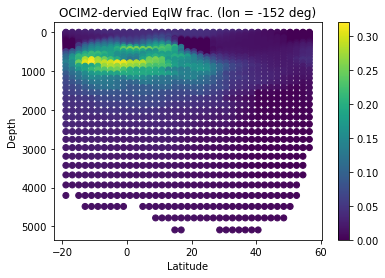

LCDW
zero out len: 405386
multiplied
starting init
starting copy
finished copy
ending init
convergence sum: 0.6339681781331256
convergence max: 3.890405613854453e-05
5000
Time: 31.877572774887085 s
convergence sum: 0.35661288835082766
convergence max: 1.9790509508954557e-05
10000
Time: 65.27774000167847 s
convergence sum: 0.3286857331727706
convergence max: 1.5529556793181243e-05
15000
Time: 98.54173994064331 s
convergence sum: 0.3157240068617407
convergence max: 1.3057124805759823e-05
20000
Time: 131.1797969341278 s
convergence sum: 0.3059882346608628
convergence max: 1.1277027533396211e-05
25000
Time: 164.73134088516235 s
convergence sum: 0.29677143199487294
convergence max: 9.662834383250551e-06
30000
Time: 197.6793098449707 s
convergence sum: 0.2872261397036844
convergence max: 8.514155792616052e-06
35000
Time: 229.87709069252014 s
convergence sum: 0.27728974925932365
convergence max: 7.671149845567271e-06
40000
Time: 262.0233428478241 s
convergence sum: 0.2671589814678466
converge

convergence sum: 0.031848730349448545
convergence max: 4.1638210926397967e-07
380000
Time: 2483.9166009426117 s
convergence sum: 0.03109652417434915
convergence max: 4.135512271241648e-07
385000
Time: 2516.514813899994 s
convergence sum: 0.030367592726891896
convergence max: 4.112450315840732e-07
390000
Time: 2549.164270877838 s
convergence sum: 0.02966109960550529
convergence max: 4.0878765023011354e-07
395000
Time: 2582.2887029647827 s
convergence sum: 0.028976240494857412
convergence max: 4.0618754648669153e-07
400000
Time: 2615.2965829372406 s
convergence sum: 0.028312241831734128
convergence max: 4.0345299273658597e-07
405000
Time: 2647.47589302063 s
convergence sum: 0.027668359540613068
convergence max: 4.005920606064972e-07
410000
Time: 2680.8439388275146 s
convergence sum: 0.027043877833136713
convergence max: 3.976126195653906e-07
415000
Time: 2713.236261844635 s
convergence sum: 0.026438108067216148
convergence max: 3.9452232465653214e-07
420000
Time: 2745.5068287849426 s
con

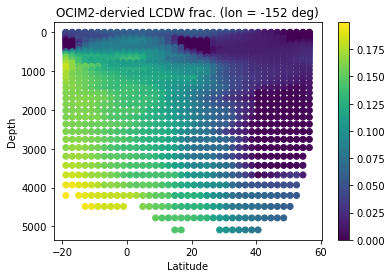

NPIW
zero out len: 405386
multiplied
starting init
starting copy
finished copy
ending init
convergence sum: 0.3131841979043976
convergence max: 4.715457695220193e-05
5000
Time: 32.52819204330444 s
convergence sum: 0.25907663929868346
convergence max: 3.255960439224603e-05
10000
Time: 64.0461962223053 s
convergence sum: 0.2063032028765952
convergence max: 2.179264338292297e-05
15000
Time: 96.68027400970459 s
convergence sum: 0.15734764204267745
convergence max: 1.385706336004544e-05
20000
Time: 128.30419301986694 s
convergence sum: 0.12223125484956542
convergence max: 1.1582593564041233e-05
25000
Time: 160.54981899261475 s
convergence sum: 0.09966384193086814
convergence max: 9.553444341059425e-06
30000
Time: 193.39625310897827 s
convergence sum: 0.08501552776990372
convergence max: 7.762669052890914e-06
35000
Time: 225.9066460132599 s
convergence sum: 0.07495320003582281
convergence max: 6.958953362889986e-06
40000
Time: 259.35851407051086 s
convergence sum: 0.0676303582361058
converge

convergence sum: 0.010285296791394142
convergence max: 1.9611107662798055e-07
375000
Time: 2432.015242099762 s
convergence sum: 0.010113029434898994
convergence max: 1.929488046142902e-07
380000
Time: 2464.7771899700165 s
convergence sum: 0.009944304809268927
convergence max: 1.8984918821740582e-07
385000
Time: 2496.991646051407 s
convergence sum: 0.009779031359618807
convergence max: 1.8681234542627934e-07
390000
Time: 2529.508527994156 s
convergence sum: 0.009617121997562834
convergence max: 1.8383808206290375e-07
395000
Time: 2562.639785051346 s
convergence sum: 0.009458493567849868
convergence max: 1.8092594125662664e-07
400000
Time: 2596.1187660694122 s
convergence sum: 0.00930306638425224
convergence max: 1.7812049936394292e-07
405000
Time: 2628.726161003113 s
convergence sum: 0.009150763828196901
convergence max: 1.7613492715728984e-07
410000
Time: 2660.3467669487 s
convergence sum: 0.009001512004424275
convergence max: 1.7414975175822356e-07
415000
Time: 2692.807697057724 s
con

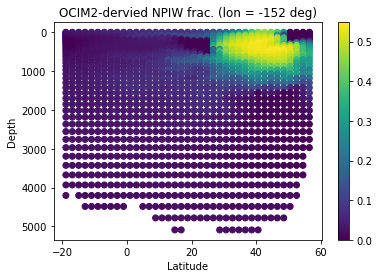

PDW
zero out len: 405386
multiplied
starting init
starting copy
finished copy
ending init
convergence sum: 0.32481605984605366
convergence max: 1.1967560629128071e-05
5000
Time: 32.660834074020386 s
convergence sum: 0.0659680592484232
convergence max: 8.12506464553664e-06
10000
Time: 64.39187622070312 s
convergence sum: 0.05378301103077326
convergence max: 5.7959130491461175e-06
15000
Time: 97.08332014083862 s
convergence sum: 0.048347918973652294
convergence max: 5.222656427078531e-06
20000
Time: 129.79872107505798 s
convergence sum: 0.044300362981869436
convergence max: 4.386874687872799e-06
25000
Time: 161.5295753479004 s
convergence sum: 0.04110732129710444
convergence max: 3.535034469898113e-06
30000
Time: 194.85134840011597 s
convergence sum: 0.03848526073130591
convergence max: 2.8159546512918077e-06
35000
Time: 227.39893507957458 s
convergence sum: 0.03624912299501763
convergence max: 2.2140412684334976e-06
40000
Time: 259.9009222984314 s
convergence sum: 0.03428711317824885
co

convergence sum: 0.004933525680369201
convergence max: 6.213265540955248e-08
375000
Time: 2426.0892810821533 s
convergence sum: 0.004835205901309373
convergence max: 6.141120362235242e-08
380000
Time: 2455.4350912570953 s
convergence sum: 0.00473946992212254
convergence max: 6.070137495775563e-08
385000
Time: 2485.732453107834 s
convergence sum: 0.00464623392232901
convergence max: 6.000315191587169e-08
390000
Time: 2516.6990401744843 s
convergence sum: 0.0045554175572942775
convergence max: 5.9316448339924444e-08
395000
Time: 2546.5778040885925 s
convergence sum: 0.004466943722478742
convergence max: 5.8781551320885583e-08
400000
Time: 2581.5146024227142 s
convergence sum: 0.004380738340508369
convergence max: 5.832953476128666e-08
405000
Time: 2615.1027550697327 s
convergence sum: 0.004296730169716446
convergence max: 5.7872877039233384e-08
410000
Time: 2648.1446692943573 s
convergence sum: 0.004214850631980114
convergence max: 5.741218415261651e-08
415000
Time: 2680.564875125885 s
c

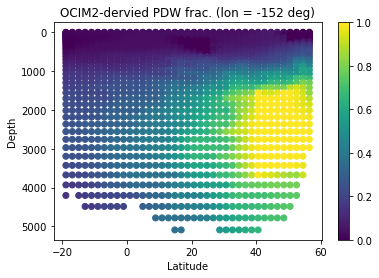

PSUW
zero out len: 405386
multiplied
starting init
starting copy
finished copy
ending init
convergence sum: 0.12287474736205856
convergence max: 6.836774561230774e-05
5000
Time: 29.611260890960693 s
convergence sum: 0.10093089976328773
convergence max: 4.206369500342477e-05
10000
Time: 61.155004024505615 s
convergence sum: 0.08494056075743218
convergence max: 3.3097332610254604e-05
15000
Time: 94.80163598060608 s
convergence sum: 0.07407921808591947
convergence max: 2.3666038315384164e-05
20000
Time: 128.0893259048462 s
convergence sum: 0.0660995836916544
convergence max: 1.7788436974863764e-05
25000
Time: 161.91556906700134 s
convergence sum: 0.05980436153564553
convergence max: 1.361215296435958e-05
30000
Time: 195.36760878562927 s
convergence sum: 0.054640598268121884
convergence max: 1.1089381187434633e-05
35000
Time: 228.6992609500885 s
convergence sum: 0.0502839303719911
convergence max: 9.442512088397859e-06
40000
Time: 261.761931180954 s
convergence sum: 0.04652462404044161
con

convergence sum: 0.0167013035230113
convergence max: 5.080966365977879e-07
375000
Time: 2495.919661998749 s
convergence sum: 0.01654001985297043
convergence max: 4.987422548285991e-07
380000
Time: 2530.39292883873 s
convergence sum: 0.016377775248580646
convergence max: 4.895913775504468e-07
385000
Time: 2564.018134832382 s
convergence sum: 0.016214747309136038
convergence max: 4.806426477377279e-07
390000
Time: 2598.785166978836 s
convergence sum: 0.016051105901782596
convergence max: 4.718940174452957e-07
395000
Time: 2632.6522369384766 s
convergence sum: 0.015887012759821836
convergence max: 4.6399177111577927e-07
400000
Time: 2664.9291620254517 s
convergence sum: 0.015722621219713455
convergence max: 4.57871159570411e-07
405000
Time: 2698.546375989914 s
convergence sum: 0.015558076079440021
convergence max: 4.517737982601133e-07
410000
Time: 2731.524132013321 s
convergence sum: 0.015393513562198891
convergence max: 4.457051270001511e-07
415000
Time: 2765.31969499588 s
convergence s

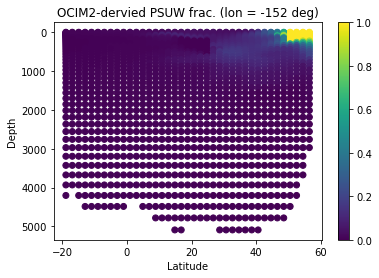

SPCW
zero out len: 405386
multiplied
starting init
starting copy
finished copy
ending init
convergence sum: 0.12350669604115877
convergence max: 2.6622393181685577e-05
5000
Time: 35.41888475418091 s
convergence sum: 0.10684921338787122
convergence max: 2.004331123409142e-05
10000
Time: 69.43210697174072 s
convergence sum: 0.1065742177082899
convergence max: 1.5418668719818784e-05
15000
Time: 103.48541498184204 s
convergence sum: 0.10778521601222445
convergence max: 1.2626380384239688e-05
20000
Time: 138.96573495864868 s
convergence sum: 0.10914770562865754
convergence max: 1.0207822128571742e-05
25000
Time: 183.67635107040405 s
convergence sum: 0.11014267968344768
convergence max: 8.83095924425481e-06
30000
Time: 233.26715087890625 s
convergence sum: 0.11044606987950246
convergence max: 8.266428492081923e-06
35000
Time: 283.165452003479 s
convergence sum: 0.10986862177405225
convergence max: 7.793231446645565e-06
40000
Time: 325.97210693359375 s
convergence sum: 0.10837327131016179
con

convergence sum: 0.010652847992244353
convergence max: 1.2564265711167977e-07
375000
Time: 2628.3748478889465 s
convergence sum: 0.01035444667540263
convergence max: 1.2025275625271448e-07
380000
Time: 2663.0314440727234 s
convergence sum: 0.010066552588941926
convergence max: 1.1506433764130186e-07
385000
Time: 2697.9790148735046 s
convergence sum: 0.00978874630866486
convergence max: 1.1007252756489727e-07
390000
Time: 2734.4488739967346 s
convergence sum: 0.009520626439114206
convergence max: 1.0527231167345441e-07
395000
Time: 2769.937655687332 s
convergence sum: 0.009261808805979772
convergence max: 1.0065857089514019e-07
400000
Time: 2805.4813330173492 s
convergence sum: 0.009011925682870374
convergence max: 9.622610872006554e-08
405000
Time: 2841.9903428554535 s
convergence sum: 0.008770625051138821
convergence max: 9.196968318858634e-08
410000
Time: 2877.382670879364 s
convergence sum: 0.008537569892569517
convergence max: 8.788402401649353e-08
415000
Time: 2912.490005970001 s


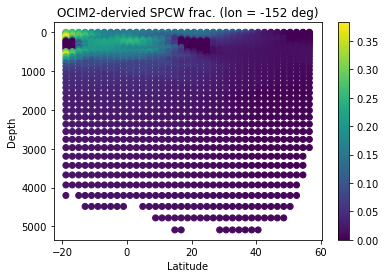

SPSTSW
zero out len: 405386
multiplied
starting init
starting copy
finished copy
ending init
convergence sum: 0.05000632624302447
convergence max: 8.965795666601717e-06
5000
Time: 30.112600803375244 s
convergence sum: 0.042149686503686515
convergence max: 5.20750544508175e-06
10000
Time: 60.20912194252014 s
convergence sum: 0.04015445575532702
convergence max: 3.449742701999714e-06
15000
Time: 94.01341199874878 s
convergence sum: 0.039188193362439824
convergence max: 2.5303076007093805e-06
20000
Time: 127.23636269569397 s
convergence sum: 0.03871253071913019
convergence max: 1.977645865791633e-06
25000
Time: 160.03543782234192 s
convergence sum: 0.0384337827420389
convergence max: 1.7417867119590147e-06
30000
Time: 193.0728099346161 s
convergence sum: 0.03815435911922597
convergence max: 1.6366522590099963e-06
35000
Time: 225.23265480995178 s
convergence sum: 0.037777911719021576
convergence max: 1.5463654607292265e-06
40000
Time: 258.1869320869446 s
convergence sum: 0.0372767899063143

convergence sum: 0.004190870639390705
convergence max: 5.66738473442574e-08
375000
Time: 2468.9672400951385 s
convergence sum: 0.004073670800560353
convergence max: 5.410096456937019e-08
380000
Time: 2502.3250238895416 s
convergence sum: 0.003960590110976963
convergence max: 5.163529677443268e-08
385000
Time: 2535.3875839710236 s
convergence sum: 0.0038514633075278637
convergence max: 4.927325050751996e-08
390000
Time: 2568.8932518959045 s
convergence sum: 0.0037461324647793167
convergence max: 4.70112716047244e-08
395000
Time: 2602.428421974182 s
convergence sum: 0.003644446629956112
convergence max: 4.48458549393016e-08
400000
Time: 2635.3604917526245 s
convergence sum: 0.003546261478178211
convergence max: 4.277354852949555e-08
405000
Time: 2667.9617760181427 s
convergence sum: 0.0034514389868649112
convergence max: 4.079096202480592e-08
410000
Time: 2700.0528259277344 s
convergence sum: 0.003359847128237624
convergence max: 3.889477381141537e-08
415000
Time: 2733.946933031082 s
con

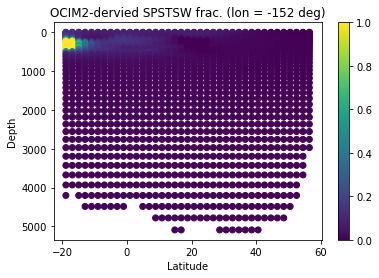

UCDW
zero out len: 405386
multiplied
starting init
starting copy
finished copy
ending init
convergence sum: 0.13002161670887838
convergence max: 1.9067545057038782e-06
5000
Time: 32.29491972923279 s
convergence sum: 0.04110411316140379
convergence max: 1.0835272475084867e-06
10000
Time: 65.4293737411499 s
convergence sum: 0.0366051632667866
convergence max: 7.298993148791705e-07
15000
Time: 98.20708560943604 s
convergence sum: 0.0350925573320883
convergence max: 5.701945591952279e-07
20000
Time: 131.40455985069275 s
convergence sum: 0.03404455663950568
convergence max: 4.84540716156126e-07
25000
Time: 163.7778775691986 s
convergence sum: 0.03307108585212572
convergence max: 4.097323551763288e-07
30000
Time: 198.0443136692047 s
convergence sum: 0.0320572434716729
convergence max: 3.891403869710902e-07
35000
Time: 232.06243085861206 s
convergence sum: 0.030991562864529178
convergence max: 3.767875066638948e-07
40000
Time: 265.14962887763977 s
convergence sum: 0.029897618839124743
converg

convergence sum: 0.0038291918328479976
convergence max: 4.820114817699617e-08
375000
Time: 2466.056084871292 s
convergence sum: 0.0037386474440535733
convergence max: 4.782307303809186e-08
380000
Time: 2499.8891298770905 s
convergence sum: 0.0036509094934988858
convergence max: 4.756064024037665e-08
385000
Time: 2532.8699645996094 s
convergence sum: 0.00356587663366003
convergence max: 4.729415664303516e-08
390000
Time: 2566.211387872696 s
convergence sum: 0.0034834514576400286
convergence max: 4.7010980179854056e-08
395000
Time: 2598.561735868454 s
convergence sum: 0.003403540331136345
convergence max: 4.6712038483803786e-08
400000
Time: 2631.3319869041443 s
convergence sum: 0.003326053233237404
convergence max: 4.639823860362602e-08
405000
Time: 2661.4449207782745 s
convergence sum: 0.00325090360537887
convergence max: 4.6070465470338107e-08
410000
Time: 2690.806023836136 s
convergence sum: 0.0031780082080151307
convergence max: 4.5729581642228734e-08
415000
Time: 2719.2496948242188 

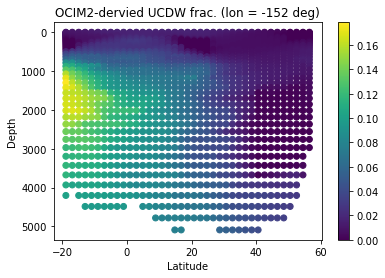

In [234]:
import scipy.sparse
from collections import OrderedDict
import time

class GetSteadyStateFracs(object):
    
    def __init__(self, base_transition_prob_mat, endmem_to_nonzeroidxs, main_endmem):
        
        rows_to_zeroout = np.ones(base_transition_prob_mat.shape[0])
        print("zero out len:",len(rows_to_zeroout))
        for nonzeroidxs in endmem_to_nonzeroidxs.values():
            for idx in nonzeroidxs:
                rows_to_zeroout[idx] = 0.0
        rowzerod_trprobmat = scipy.sparse.diags(rows_to_zeroout) @ base_transition_prob_mat
        
        print("multiplied")
        self.endmem_to_trmatandinitvec = OrderedDict()
        self.endmem_to_lateststatevec = OrderedDict()
        
        print("starting init")
        self.trmat, self.initvec = self.get_trmat_and_initvec_for_endmem(
                            rowzerod_trprobmat=rowzerod_trprobmat,
                            endmem_nonzeroidxs=endmem_to_nonzeroidxs[main_endmem])
        print("ending init")
        self.lateststatevec = self.initvec
        self.total_timesteps = 0
        self.diff_from_prev = None
        
    @staticmethod
    def get_trmat_and_initvec_for_endmem(rowzerod_trprobmat, endmem_nonzeroidxs):
        print("starting copy")
        new_rowzerod_trprobmat = rowzerod_trprobmat.tolil()
        print("finished copy")
        init_label_vec = np.zeros(rowzerod_trprobmat.shape[0])
        for idx in endmem_nonzeroidxs:
            new_rowzerod_trprobmat[idx,idx] = 1.0
            init_label_vec[idx] = 1.0
        return new_rowzerod_trprobmat.tocsc(), init_label_vec
    
    def take_step(self, num_timesteps=1):
        for i in range(num_timesteps):
            oldvec = self.lateststatevec
            self.lateststatevec = (self.trmat @ self.lateststatevec)
            self.diff_from_prev = self.lateststatevec - oldvec
            self.total_timesteps += 1
        print("convergence sum:",np.sum(np.abs(self.diff_from_prev)))
        print("convergence max:",np.max(np.abs(self.diff_from_prev)))
        
    
endmem_to_lateststatevec = OrderedDict()
for endmem in sorted(endmem_to_nonzeroidxs.keys()):
    #endmem='NPIW'
    print(endmem)
    ss_fracs = GetSteadyStateFracs(base_transition_prob_mat=transition_prob_mat,
                                   endmem_to_nonzeroidxs=endmem_to_nonzeroidxs,
                                   main_endmem=endmem)

    start = time.time()
    for i in range(100):
        ss_fracs.take_step(num_timesteps=5000)
        print(ss_fracs.total_timesteps)
        print("Time:", time.time()-start,"s")

    endmem_to_lateststatevec[endmem] = ss_fracs.lateststatevec
        
    #get the cells corresponding to the gp15 cruise
    gp15_idxs = get_nonzero_idxs(lon_min=-152, lon_max=-152, lat_min=-20, lat_max=60)

    plt.scatter(
        ulat_ocnvec[gp15_idxs],
        depth_ocnvec[gp15_idxs],
        c=ss_fracs.lateststatevec[gp15_idxs],
        #vmin=0.0, vmax=1.0
    )
    plt.ylim(plt.ylim()[1], plt.ylim()[0])
    plt.ylabel("Depth")
    plt.xlabel("Latitude")
    plt.title("OCIM2-dervied "+endmem+" frac. (lon = -152 deg)")
    plt.colorbar()
    plt.show()

In [242]:
import scipy.io

scipy.io.savemat(file_name="50ksteps.mat", mdict=endmem_to_lateststatevec)

In [241]:
!rm 50ksteps 50ksteps.at

50ksteps
50ksteps.at
Explore Holzer 2021 Fluxes.ipynb
GP15_Bottle_Leg1.mat
GP15_Bottle_Leg2.mat
OCIM2_48L_base_data.nc
OCIM2_48L_base_transport.mat
SteadyStateAlongGP15fromHolzerFluxes.ipynb


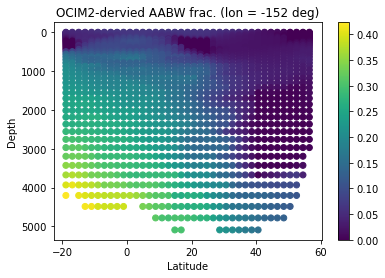

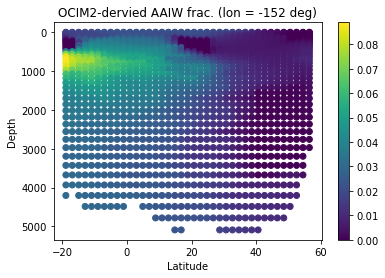

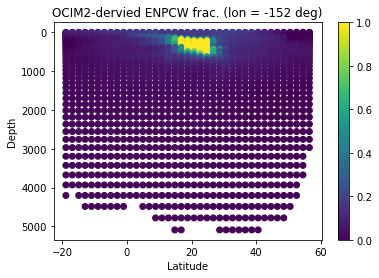

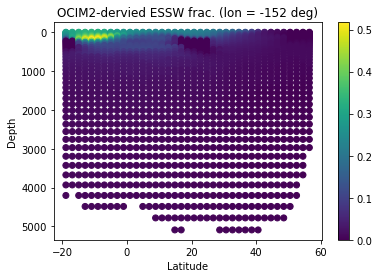

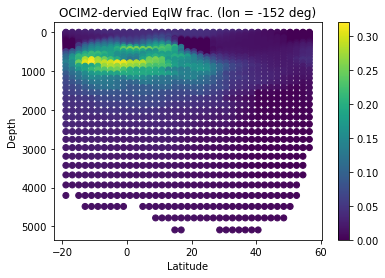

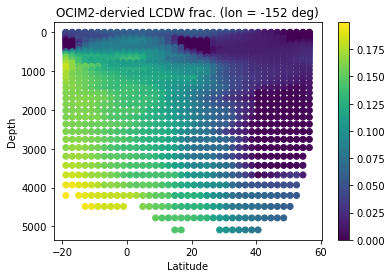

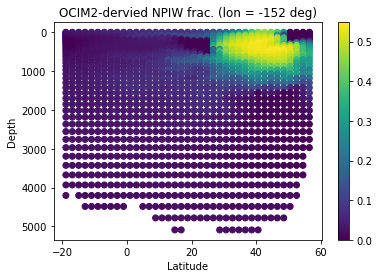

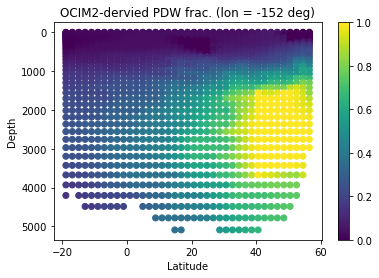

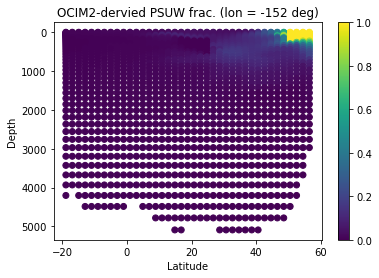

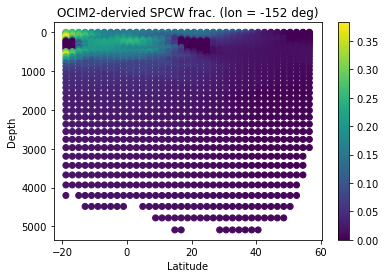

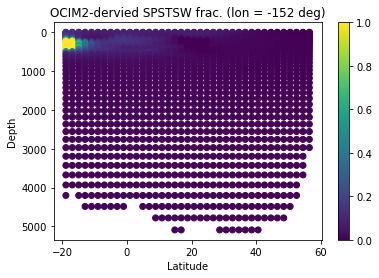

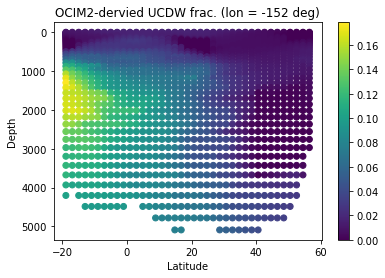

In [235]:
for endmem in endmem_to_lateststatevec:
    plt.scatter(
        ulat_ocnvec[gp15_idxs],
        depth_ocnvec[gp15_idxs],
        c=endmem_to_lateststatevec[endmem][gp15_idxs],
        #vmin=0.0, vmax=1.0
    )
    plt.ylim(plt.ylim()[1], plt.ylim()[0])
    plt.ylabel("Depth")
    plt.xlabel("Latitude")
    plt.title("OCIM2-dervied "+endmem+" frac. (lon = -152 deg)")
    plt.colorbar()
    plt.show()

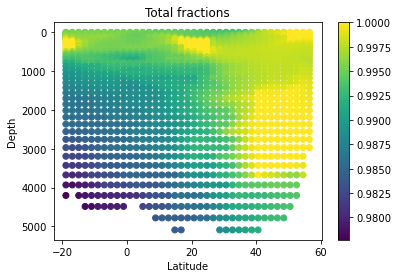

In [236]:
plt.scatter(
        ulat_ocnvec[gp15_idxs],
        depth_ocnvec[gp15_idxs],
        c=(np.sum(np.array(list(endmem_to_lateststatevec.values())), axis=0))[gp15_idxs],
        #vmin=0.0, vmax=1.0
    )
plt.ylim(plt.ylim()[1], plt.ylim()[0])
plt.ylabel("Depth")
plt.xlabel("Latitude")
plt.title("Total fractions")
plt.colorbar()
plt.show()

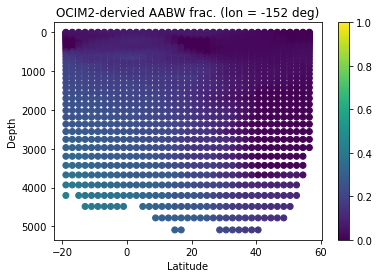

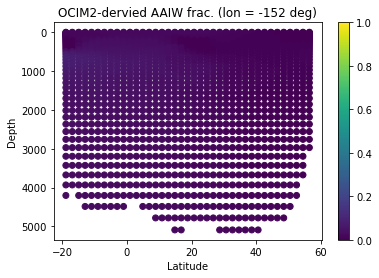

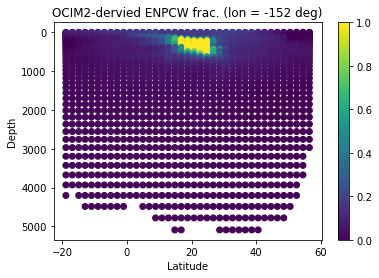

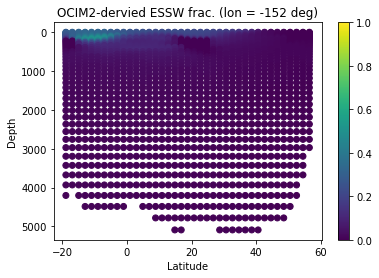

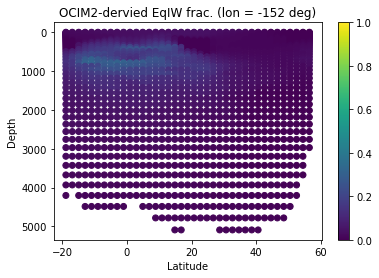

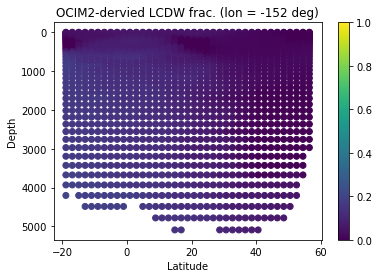

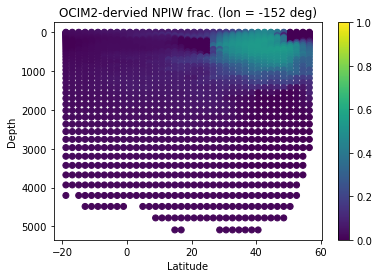

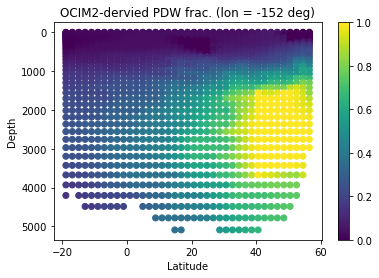

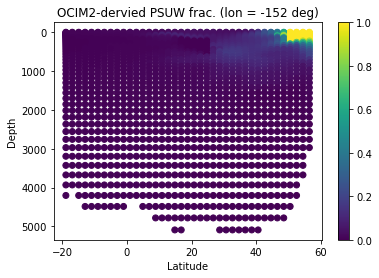

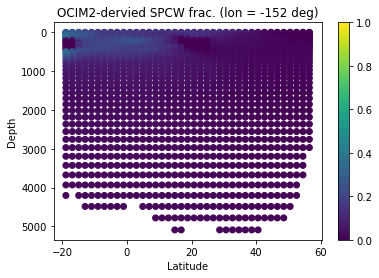

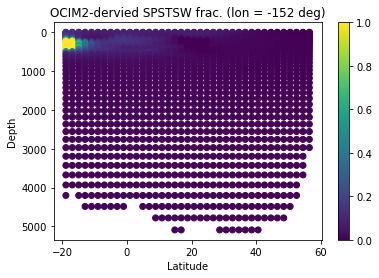

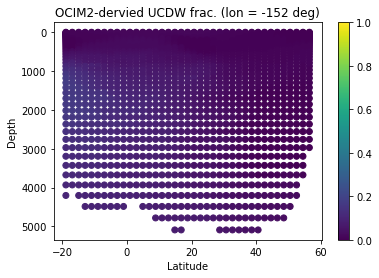

In [237]:
for endmem in endmem_to_lateststatevec:
    plt.scatter(
        ulat_ocnvec[gp15_idxs],
        depth_ocnvec[gp15_idxs],
        c=endmem_to_lateststatevec[endmem][gp15_idxs],
        vmin=0.0, vmax=1.0
    )
    plt.ylim(plt.ylim()[1], plt.ylim()[0])
    plt.ylabel("Depth")
    plt.xlabel("Latitude")
    plt.title("OCIM2-dervied "+endmem+" frac. (lon = -152 deg)")
    plt.colorbar()
    plt.show()